In [2]:
from models.Unet import UNet
from dataset.data import BatchMaker
import pandas as pd
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random
import wandb
import datetime
from utils.metrics import SegmentationMetrics
from utils.metrics2 import calculate_iou, calculate_ap_for_segmentation
import segmentation_models_pytorch as smp
import cv2
import os

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/tmp/ipykernel_436912/2803100531.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [16]:
num_classes = 4

path_dict ={'laptop':'/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Kod/config/config_laptop.yaml',
            'lab':'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml',
            'komputer':'/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
            } 

model_dict = {'myUNet': UNet(3,num_classes),
              'smpUNet': smp.Unet(in_channels = 3, classes=num_classes),
              'smpUNet++': smp.UnetPlusPlus(in_channels = 3, classes=num_classes,encoder_name="resnet18",encoder_weights=None),
}


# wandb.init(project="noisy_labels", entity="segsperm",
#             config={
#             "model": "smpUNet++",
#             "batch_size": 1,
#             "annotator": 1,
#             "place": 'lab',
#             "mode": "intersection_inference"
#             })
# 
# config = wandb.config

with open(path_dict[config.place], 'r') as config_file:
    yaml_config = yaml.safe_load(config_file)

saved_model_name = 'Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass'
model_path = yaml_config['save_model_path'] + '/' + saved_model_name

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)  
    print("GPU dostępne:", gpu_name ) 
    device = torch.device("cuda")
else:
    raise Exception("Brak dostępnej karty GPU.")


model = model_dict[config.model]
model.load_state_dict(torch.load(model_path)) 
model.to(device)


img = cv2.imread("/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/example_blur.png")
x_img = img.astype(np.float32)

# Normalize images
min_val = np.min(x_img)
max_val = np.max(x_img)
x_img = (x_img - min_val) / (max_val - min_val)
x_img = np.expand_dims(x_img, axis=0)
x = np.transpose(x_img,(0,3,1,2))
x_tensor = torch.from_numpy(x)

inputs = x_tensor.to(device)
outputs = model(inputs)
output1 = outputs[:,:3, :, :]
output2 = outputs[:,[0, -1], :, :]

preds1 = torch.argmax(output1, dim=1)
preds2 = torch.argmax(output2, dim=1)
softs1 = torch.softmax(output1, dim=1)
softs1 = softs1.squeeze(0)
softs2 = torch.softmax(output2, dim=1)
softs2 = softs2.squeeze(0)

threshold_oneclass = 0.2953
threshold_head = 0.4606
threshold_tail = 0.6378



softmask_multiclass_np = np.array(softs1.cpu().detach())
softmask_multiclass_np = softmask_multiclass_np.transpose(1,2,0)

softmask_head_np = softmask_multiclass_np[:,:,2]
softmask_tail_np = softmask_multiclass_np[:,:,1]

softmask_oneclass_np = np.array(softs2.cpu().detach())
softmask_oneclass_np = softmask_oneclass_np.transpose(1,2,0)




pred_head = (softmask_head_np > threshold_head).astype(float)
pred_tail = (softmask_tail_np > threshold_tail).astype(float)


final_mask = np.zeros_like(pred_head)
conflict = (pred_head == 1) & (pred_tail == 1)
tail_conflict_values = softmask_tail_np[conflict]
head_conflict_values = softmask_head_np[conflict]
final_mask[conflict] = 2 - (tail_conflict_values > head_conflict_values).astype(int)  # 1 dla tail, 2 dla head
final_mask[(pred_tail == 1) & ~conflict] = 1
final_mask[(pred_head == 1) & ~conflict] = 2

pred_oneclass = (softmask_oneclass_np > threshold_oneclass).astype(float)
pred_oneclass = pred_oneclass[:,:,1]



GPU dostępne: NVIDIA GeForce RTX 3090


In [25]:
colors = [[0, 0, 0], [0, 255, 0], [0, 0, 255]]  # tło, wić, główka

output = final_mask
new_mask2 = np.zeros((512, 512))
for i in range(3):
    new_mask2[final_mask[i] == 1] = i
    
mask_to_display = final_mask

mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    mask_rgb[mask_to_display == i] = color

True

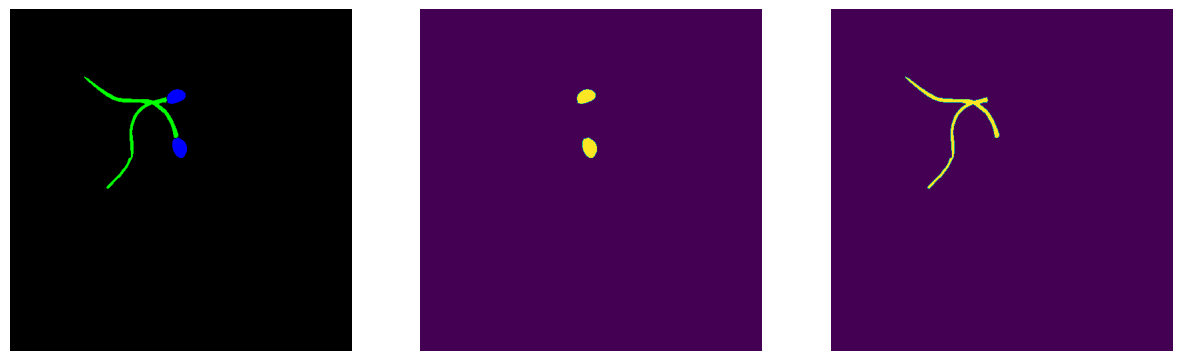

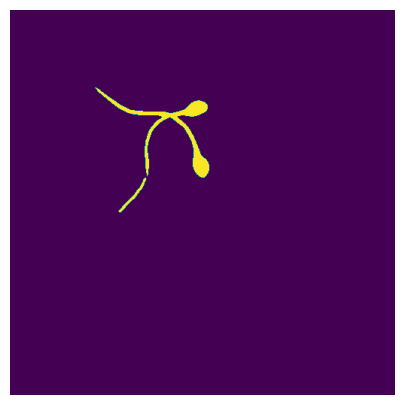

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(mask_rgb)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(pred_head)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(pred_tail)
plt.axis('off')
plt.figure(figsize=(15,5))
plt.imshow(pred_oneclass)
plt.axis('off')

cv2.imwrite("/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/final_pred.png", mask_rgb)

True

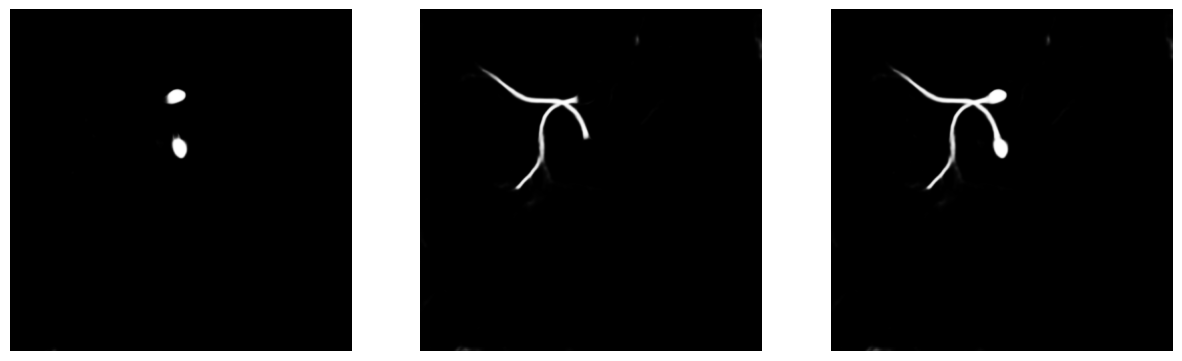

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(softmask_head_np,cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(softmask_tail_np,cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(softmask_tail_np+softmask_head_np,cmap='gray')
plt.axis('off')

cv2.imwrite("/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/softmask_full.png", (softmask_tail_np+softmask_head_np)*255)
cv2.imwrite("/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/softmask_head.png", softmask_head_np*255)
cv2.imwrite("/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/softmask_tail.png", softmask_tail_np*255)


(-0.5, 511.5, 511.5, -0.5)

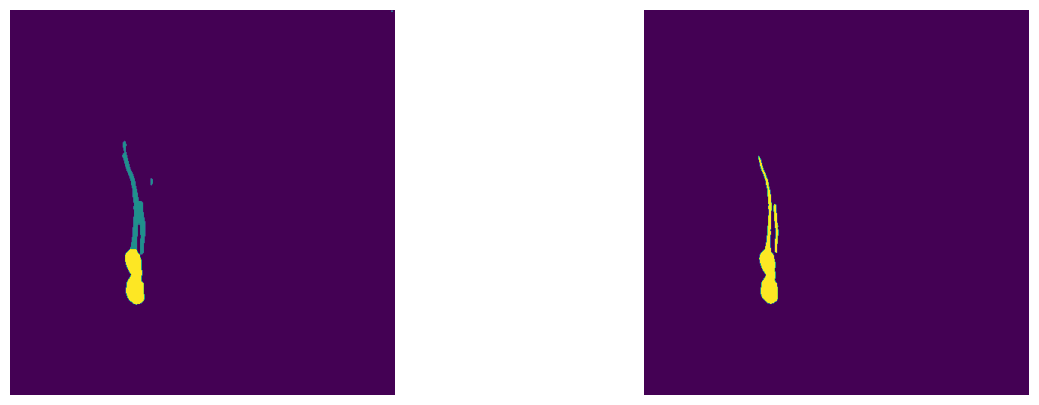

In [68]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(preds1.cpu().detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(preds2.cpu().detach().numpy().transpose(1,2,0))
plt.axis('off')